#IMDB Sentiment Analysis - Feed-Forward Neural Nets
Georgios - Alexandros Vasilakopoulos

In [ ]:
import numpy as np
import torch
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

##Loading the data:

In [ ]:
data_path = 'drive/MyDrive/ML/AI2/imdb-reviews.csv'
test_path = None #Insert the path here for testing

data = pd.read_csv(data_path, sep = '\t')
X = data['review']
Y = data[['rating']]

Y.loc[Y['rating'] < 7.0, 'rating']=0
Y.loc[Y['rating'] >= 7.0, 'rating']=1


if test_path:
    test_dataset = pd.read_csv(data_path, sep = '\t')
    X_test = test_dataset['review']
    Y_test = test_dataset[['rating']]
    Y_test.loc[Y_test['rating'] < 7.0, 'rating']=0
    Y_test.loc[Y_test['rating'] >= 7.0, 'rating']=1
else:
    X,X_test,Y,Y_test = train_test_split(X,Y,test_size=0.2, shuffle = True) #Partition of the dataset

X,X_validation,Y,Y_validation = train_test_split(X,Y,test_size=0.2, shuffle = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


##Data Preprocessing

###GloVe Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-12-21 22:39:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-21 22:39:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-21 22:39:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


###Defining a custom vectorizer that uses GloVe embeddings:

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


class myVectorizer():
    def __init__(self, w2v_output_file):
        self.model = KeyedVectors.load_word2vec_format(w2v_output_file, binary = False)
        self.calc = False

    def transform(self,X):
        X_transformed = []
        stopword_set = set(stopwords.words())                           #Remove stopwords
        for instance in X:
            instance = re.sub(r'[^a-z ]+', '', instance.lower())        #Transform upper case letters to lower case and keep only letters.
            word_list = word_tokenize(instance)
            word_list = [word for word in word_list if not word in stopword_set]
            vector_list = []
            for word in word_list:
                if word in self.model.vocab:                            #If word is in vocabulary, add the corresponding vector
                    vector_list +=[self.model[word]]
            if len(vector_list)>0:
                X_transformed +=[sum(vector_list)/len(vector_list)]     #Return the average of the vectors of a review

        X_transformed = np.asmatrix(X_transformed)


        #If this is the training data, find mean and std for standardization
        if self.calc == False:
            self.calc = True
            self.mean = np.mean(X_transformed,axis = 0)
            self.std = np.std(X_transformed,axis = 0)

        #Standardize data
        for row in X_transformed:
            row = (row - self.mean)/self.std

        return X_transformed

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


###Initialize Dataloaders

In [ ]:
glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'
glove2word2vec(glove_input_file, w2v_output_file)


vectorizer = myVectorizer(w2v_output_file)

#Creating Training Dataloader
x = vectorizer.transform(X)
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(np.ravel(Y), dtype=torch.long)
dataset = torch.utils.data.TensorDataset(x, y)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


#Creating Validation Dataloader
x = vectorizer.transform(X_validation)
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(np.ravel(Y_validation), dtype=torch.long)
dataset = torch.utils.data.TensorDataset(x, y)
validation_dataloader = torch.utils.data.DataLoader(dataset,batch_size=Y_validation.shape[0], shuffle=True)


#Creating Testing Dataloader
x = vectorizer.transform(X_test)
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(np.ravel(Y_test), dtype=torch.long)
dataset = torch.utils.data.TensorDataset(x, y)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size =Y_test.shape[0], shuffle = True)

##Feed-Forward Neural Network

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 27.9 MB/s 


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall
from torchmetrics.classification import F1Score
from torchmetrics.classification import Precision
from torchmetrics.classification import Recall
import matplotlib.pyplot as plt

###Building a Network, given the parameters

In [ ]:
def build_model(D_in, D_out, parameters):

    mynetwork =  nn.Sequential(
        nn.Linear(D_in, parameters['d1']),
        getattr(nn, parameters['non_linearity'])(),
        nn.Linear(parameters['d1'],D_out),
    )

    return mynetwork

###Defining the Testing Process:

In [ ]:
def Test_Network(dataloader, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    f1 = F1Score(task="binary", num_classes=2).to(device)
    pr = Precision(task="binary", num_classes=2).to(device)
    rec = Recall(task="binary", num_classes=2).to(device)


    with torch.no_grad():
        model.eval()
        X , y = dataloader.dataset[:]

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        X = X.to(device)
        y = y.to(device)

        prediction = model(X.float())
        prediction = torch.argmax(prediction,1)
        f1_measure = f1(prediction,y)
        precision = pr(prediction,y)
        recall = rec(prediction,y)



    return precision, recall, f1_measure

###Defining the Training Process

In [ ]:
def Train_Network(train_dataloader, validation_dataloader, n_epochs, parameters, model,info = False):
    cost_function = nn.CrossEntropyLoss()
    optimizer = getattr(optim, parameters['optimizer'])(model.parameters(), lr = parameters['learning_rate'])

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()
        cost_function = cost_function.cuda()

    best_model = None
    highest_f1_score = 0

    epoch_sizes = []
    val_scores = []
    train_scores = []
    for i in range(n_epochs):
        model.train()
        loss_list=[]
        avg_losses=[]
        for batch_id, (X,y) in enumerate(train_dataloader):

            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            prediction = model(X.float())
            loss = cost_function(prediction,y)
            loss_list+=[loss.item()]
            loss.backward()
            optimizer.step()
        _, _, f1_measure_val = Test_Network(validation_dataloader,model)
        if info == True:
            _, _, f1_measure_train = Test_Network(train_dataloader,model)
            epoch_sizes += [i]
            val_scores += [f1_measure_val.item()]
            train_scores += [f1_measure_train.item()]
            avg_losses+=[np.mean(loss_list)]
        if highest_f1_score < f1_measure_val:
            highest_f1_score = f1_measure_val
            best_model = model
    if info == False:
        return best_model, highest_f1_score
    return best_model, avg_losses, epoch_sizes, val_scores, train_scores

###Results on the given test set (Final Model)

In [ ]:
params = {
        'learning_rate': 0.0001,
        'optimizer': "Adam",
        'non_linearity':"ReLU",
        'd1': 121,
    }

model = build_model(300,2,params)
trained_model, _ = Train_Network(train_dataloader,validation_dataloader,40, params, model)
precision, recall, f1 = Test_Network(test_dataloader,trained_model)
print("Precision: ",precision.item())
print("Recall: ",recall.item())
print("f1 measure: ",f1.item())

Precision:  0.8456621170043945
Recall:  0.82146817445755
f1 measure:  0.8333895802497864


###Learning Curve & ROC Curve (Final Model):

In [ ]:
def make_prediction(X,model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X = X.to(device)
        prediction = model(X.float())
        prediction = torch.argmax(prediction,1)

    return prediction


In [ ]:
params = {
        'learning_rate': 0.0001,
        'optimizer': "Adam",
        'non_linearity':"ReLU",
        'd1': 121
    }

model = build_model(300,2,params)

trained_model, avg_losses, epoch_sizes, val_scores, train_scores = Train_Network(train_dataloader,validation_dataloader,16, params, model,info = True)

In [ ]:
precision, recall, f1 = Test_Network(test_dataloader,trained_model)
print("Precision: ",precision.item())
print("Recall: ",recall.item())
print("f1 measure: ",f1.item())

X,y_actual = test_dataloader.dataset[:]
y_predicted = make_prediction(X,trained_model)
y_predicted = np.asarray(y_predicted.cpu())
y_actual = np.asarray(y_actual.cpu())

Precision:  0.8305010199546814
Recall:  0.8345531225204468
f1 measure:  0.8325220942497253


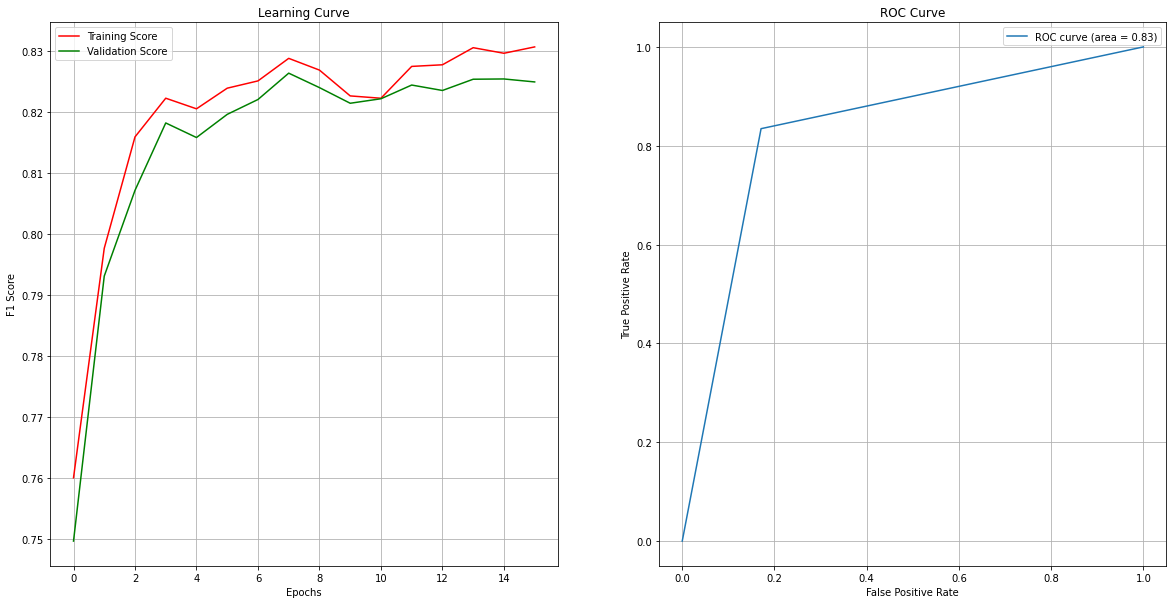

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fp,tp,_ = roc_curve(y_actual, y_predicted)
roc_auc = auc(fp,tp)

_, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("F1 Score")
axes[0].grid()

axes[0].plot(epoch_sizes, train_scores, color="r", label="Training Score")
axes[0].plot(epoch_sizes, val_scores, color="g", label="Validation Score")
axes[0].legend(loc="best")

axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].grid()
axes[1].plot(fp, tp, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].legend(loc = "best")


##Hyperparameter Selection

###Optuna Installation

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 30.9 MB/s 
     |████████████████████████████████| 210 kB 71.9 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 78 kB 7.7 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 147 kB 58.9 MB/s 
     |████████████████████████████████| 112 kB 68.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=b44955c553c187f31fc458cd98713c7994ce38dceb2b5697d04a632b50d8058b
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Uninstalling importlib-metadata-5.1.0:
      Successfully uninstalled importlib-metadata-5.1.0


In [ ]:
import optuna

###Defining the Hyperparameter Search Space

In [ ]:
def objective(trial):

    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate',1e-4,1e-2),
        'optimizer':trial.suggest_categorical("optimizer",["Adam","NAdam","Adamax","SGD"]),
        'non_linearity':trial.suggest_categorical("non_linearity",["ReLU","LeakyReLU","SELU"]),
        'd1': trial.suggest_int("d1", 20, 128)
    }


    model= build_model(300,2,params)

    _,f1_measure = Train_Network(train_dataloader, validation_dataloader,40,params,model)

    return f1_measure

###Searching for the best model

In [ ]:
study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler())
study.optimize(objective, n_trials = 100)

[I 2022-12-20 22:47:18,506] A new study created in memory with name: no-name-e05a79eb-9cf2-4f60-9266-9c4510876af5
<ipython-input-22-f191d7f902d6>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate',1e-4,1e-2),
[I 2022-12-20 22:47:41,699] Trial 0 finished with value: 0.7744818925857544 and parameters: {'learning_rate': 0.0016247419699997885, 'optimizer': 'SGD', 'non_linearity': 'LeakyReLU', 'd1': 99}. Best is trial 0 with value: 0.7744818925857544.
[I 2022-12-20 22:48:05,842] Trial 1 finished with value: 0.7591120600700378 and parameters: {'learning_rate': 0.0012036876803404575, 'optimizer': 'SGD', 'non_linearity': 'LeakyReLU', 'd1': 50}. Best is trial 0 with value: 0.7744818925857544.
[I 2022-12-20 22:48:29,116] Trial 2 finished with value: 0.8345874547958374 a

###Result

According to the searching algorithm, after 100 trials, the Feed Forward Neural Network with 1 hidden layer that emerged from the search is defined by the following hyperparameters:


    learning_rate = 0.0004
    optimizer = Adam
    non_linearity = ReLU
    d1 = 121


###Evaluation

In [ ]:
params = {
        'learning_rate': 0.0004,
        'optimizer': "Adam",
        'non_linearity':"ReLU",
        'd1': 121
    }

model = build_model(300,2,params)

trained_model, avg_losses, epoch_sizes, val_scores, train_scores = Train_Network(train_dataloader,validation_dataloader,16, params, model,info = True)

precision, recall, f1 = Test_Network(test_dataloader,trained_model)
print("Precision: ",precision.item())
print("Recall: ",recall.item())
print("f1 measure: ",f1.item())

X,y_actual = test_dataloader.dataset[:]
y_predicted = make_prediction(X,trained_model)
y_predicted = np.asarray(y_predicted.cpu())
y_actual = np.asarray(y_actual.cpu())

Precision:  0.8233920335769653
Recall:  0.8602794408798218
f1 measure:  0.8414316773414612


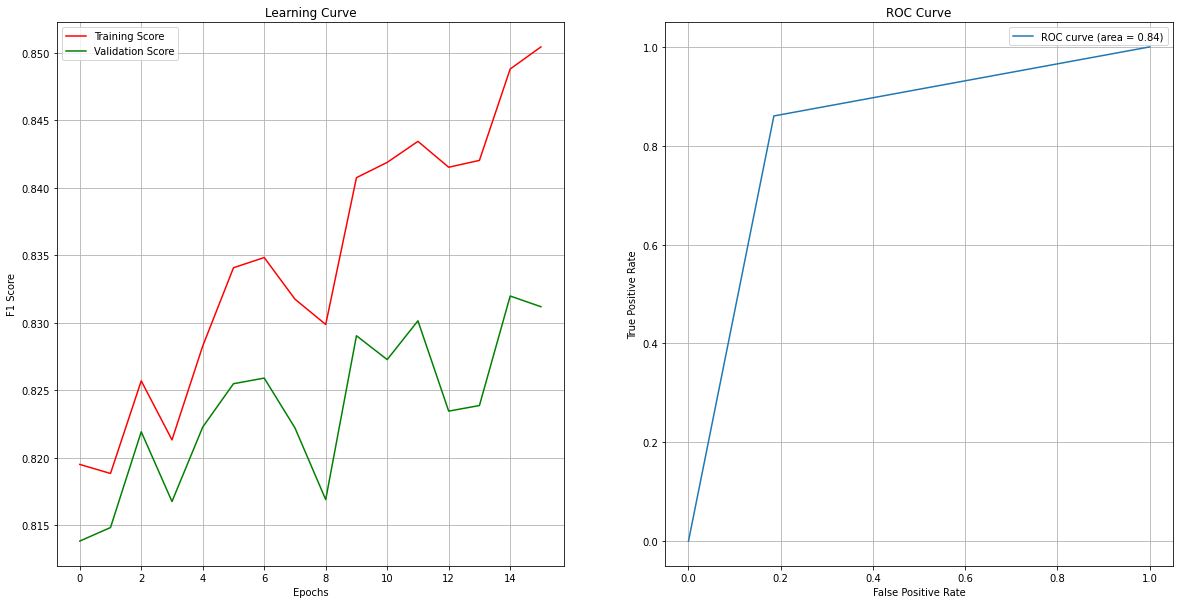

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fp,tp,_ = roc_curve(y_actual, y_predicted)
roc_auc = auc(fp,tp)

_, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("F1 Score")
axes[0].grid()

axes[0].plot(epoch_sizes, train_scores, color="r", label="Training Score")
axes[0].plot(epoch_sizes, val_scores, color="g", label="Validation Score")
axes[0].legend(loc="best")

axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].grid()
axes[1].plot(fp, tp, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].legend(loc = "best")

Even though this is the best model that resulted from the search algorithm in terms of f1 score on the validation set (0.85 peak value), it is not very stable. That is why we reduce the learning rate to 0.0001 in the Final Model.

###More than one hidden layers

In [ ]:
def build_model2(D_in, D_out, parameters):

    mynetwork =  nn.Sequential(
        nn.Linear(D_in, parameters['d1']),
        nn.Dropout(parameters['dropout']),
        getattr(nn, parameters['non_linearity'])(),
        nn.Linear(parameters['d1'],parameters['d2']),
        nn.Dropout(parameters['dropout']),
        getattr(nn, parameters['non_linearity'])(),
        nn.Linear(parameters['d2'],D_out)
    )

    return mynetwork

####Optuna Search

In [ ]:
def objective2(trial):

    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate',1e-5,1e-2),
        'optimizer':trial.suggest_categorical("optimizer",["Adam","NAdam","Adamax","SGD"]),
        'non_linearity':trial.suggest_categorical("non_linearity",["ReLU","LeakyReLU","SELU"]),
        'dropout': trial.suggest_loguniform('dropout',0.05,0.2),
        'd1': trial.suggest_int("d1", 20, 512),
        'd2': trial.suggest_int("d2", 20, 128),
    }


    model= build_model2(300,2,params)

    _,f1_measure = Train_Network(train_dataloader, validation_dataloader,40,params,model)

    return f1_measure

In [ ]:
study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler())
study.optimize(objective2, n_trials = 200)

[I 2022-12-21 01:11:21,245] A new study created in memory with name: no-name-248f3eee-e94d-4c26-b65d-2b64a3125c91
<ipython-input-93-135729a6615a>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate',1e-5,1e-2),
<ipython-input-93-135729a6615a>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'dropout': trial.suggest_loguniform('dropout',0.05,0.2),
[I 2022-12-21 01:11:53,370] Trial 0 finished with value: 0.8046694993972778 and parameters: {'learning_rate': 0.0025886549815834037, 'optimizer': 'SGD', 'non_linearity': 'ReLU', 'dropout': 0.06332852635201061, 'd1': 407, 'd2': 21}. Best is trial 0 w

####Results

After 200 trials, this is the model that produced the highest f1 score on the validation dataset:



    learning_rate = 0.00039
    optimizer = Adamax
    dropout = 0.192
    non_linearity = ReLU
    d1 = 288
    d2 = 95


#### Evaluation

In [ ]:
params = {
        'learning_rate': 0.00039,
        'optimizer': "Adamax",
        'non_linearity':"ReLU",
        'dropout':0.192,
        'd1': 288,
        'd2': 95,
    }

model = build_model2(300,2,params)

trained_model, avg_losses, epoch_sizes, val_scores, train_scores = Train_Network(train_dataloader,validation_dataloader,16, params, model,info = True)

precision, recall, f1 = Test_Network(test_dataloader,trained_model)
print("Precision: ",precision.item())
print("Recall: ",recall.item())
print("f1 measure: ",f1.item())

X,y_actual = test_dataloader.dataset[:]
y_predicted = make_prediction(X,trained_model)
y_predicted = np.asarray(y_predicted.cpu())
y_actual = np.asarray(y_actual.cpu())

Precision:  0.8394760489463806
Recall:  0.8385451436042786
f1 measure:  0.8390102982521057


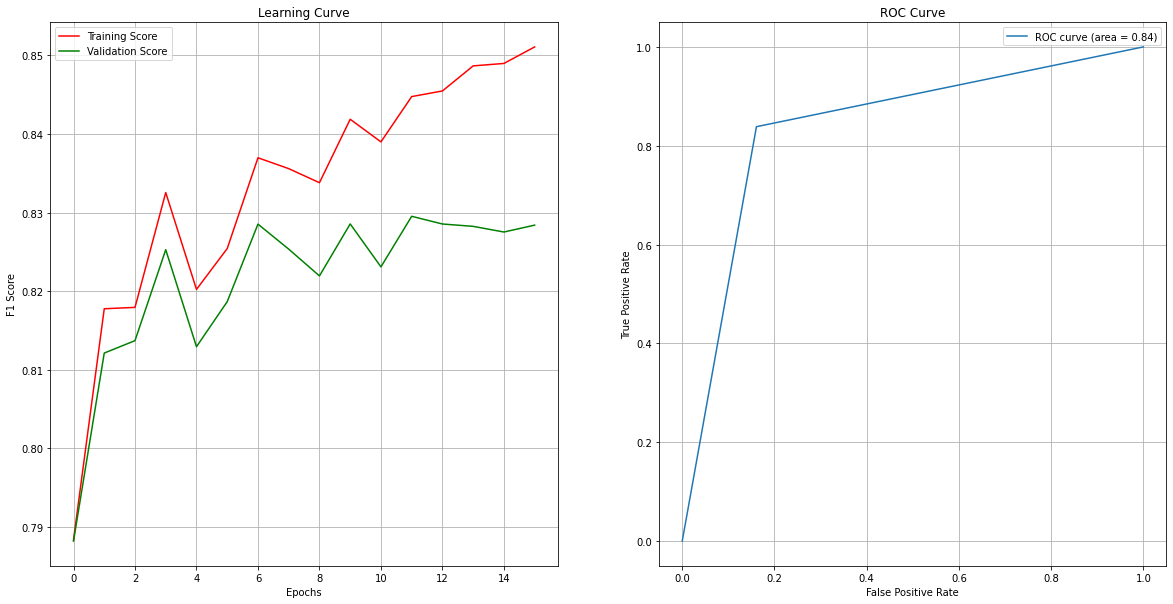

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fp,tp,_ = roc_curve(y_actual, y_predicted)
roc_auc = auc(fp,tp)

_, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].set_title("Learning Curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("F1 Score")
axes[0].grid()

axes[0].plot(epoch_sizes, train_scores, color="r", label="Training Score")
axes[0].plot(epoch_sizes, val_scores, color="g", label="Validation Score")
axes[0].legend(loc="best")

axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].grid()
axes[1].plot(fp, tp, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].legend(loc="best")

The validation score diverges quickly from the training score. This implies that overfitting occurs relatively quickly in this model of two hidden layers.